<a href="https://colab.research.google.com/github/fadhilsalih1994/Image-Processing/blob/master/Copy_of_Masked_RCNN_Field_Images_Fadhil_Salih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install mrcnn

     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54932 sha256=d3a8c7134a899f86c8973329a276234952debb9946f2815efd832e7c9ab9af7f
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


In [3]:
from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
class plantDataset(Dataset):
	# load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define both classes
        self.add_class("dataset", 1, "healthy")
        self.add_class("dataset", 2, "unhealthy")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
        # extract image id
            image_id = filename[:-4]
            # skip all images after 50 if we are building the train set
            if is_train and int(image_id) >= 51:
                continue
            # skip all images before 51 if we are building the test/val set
            if not is_train and int(image_id) < 51:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
	          # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes_new(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box and its corresponding class
        boxes = list()
        for box2 in root.findall('.//object'):
            xmin = int(box2.find('bndbox/xmin').text)
            ymin = int(box2.find('bndbox/ymin').text)
            xmax = int(box2.find('bndbox/xmax').text)
            ymax = int(box2.find('bndbox/ymax').text)
            class1 = str(box2.find('name').text)    
            coors = [xmin, ymin, xmax, ymax, class1]
            boxes.append(coors)   
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes_new(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(box[4]))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
       info = self.image_info[image_id]
       return info['path']
    
# Now let's import the images
# train set
train_set = plantDataset()
train_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = plantDataset()
test_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
                          

Train: 50
Test: 10


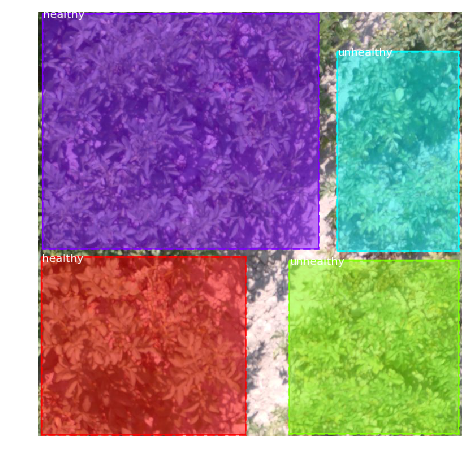

In [4]:
from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# Display the first image of the training set

# define image id
image_id = 0
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names, figsize=(8, 8))

In [5]:
from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
class plantDataset(Dataset):
	# load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "healthy")
        self.add_class("dataset", 2, "unhealthy")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
        # extract image id
            image_id = filename[:-4]
            # skip all images after 225 if we are building the train set
            if is_train and int(image_id) >= 51:
                continue
            # skip all images before 225 if we are building the test/val set
            if not is_train and int(image_id) < 51:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
	          # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes_new(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box2 in root.findall('.//object'):
            xmin = int(box2.find('bndbox/xmin').text)
            ymin = int(box2.find('bndbox/ymin').text)
            xmax = int(box2.find('bndbox/xmax').text)
            ymax = int(box2.find('bndbox/ymax').text)
            class1 = str(box2.find('name').text)    
            coors = [xmin, ymin, xmax, ymax, class1]
            boxes.append(coors)   
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes_new(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(box[4]))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
       info = self.image_info[image_id]
       return info['path']



# define a configuration for the model
class plantConfig(Config):
	# define the name of the configuration
	NAME = "plant_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 50

# train set
train_set = plantDataset()
train_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images', is_train=True)
train_set.prepare()


test_set = plantDataset()
test_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images', is_train=False)
test_set.prepare()

config = plantConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images/', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('drive/My Drive/Masters_Research_Project/Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=50, layers='heads')





Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

Using TensorFlow backend.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







Starting at epoch 0. LR=0.001

Checkpoint Path: drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images/plant_cfg20191014T0025/mask_rcnn_plant_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistribut

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/50
50/50 [==============================] - 240s 5s/step - loss: 2.5822 - rpn_class_loss: 0.1245 - rpn_bbox_loss: 0.3920 - mrcnn_class_loss: 0.5904 - mrcnn_bbox_loss: 0.7539 - mrcnn_mask_loss: 0.7213 - val_loss: 2.3959 - val_rpn_class_loss: 0.0424 - val_rpn_bbox_loss: 0.3306 - val_mrcnn_class_loss: 0.6737 - val_mrcnn_bbox_loss: 0.6771 - val_mrcnn_mask_loss: 0.6721

Epoch 2/50
50/50 [==============================] - 172s 3s/step - loss: 2.3063 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.6432 - mrcnn_bbox_loss: 0.6336 - mrcnn_mask_loss: 0.6560 - val_loss: 2.4248 - val_rpn_class_loss: 0.0392 - val_rpn_bbox_loss: 0.3412 - val_mrcnn_class_loss: 0.7371 - val_mrcnn_bbox_loss: 0.6455 - val_mrcnn_mask_loss: 0.6618
Epoch 3/50
50/50 [==============================] - 172s 3s/step - loss: 2.1452 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.2952 - mrcnn_class_loss: 0.6071 - mrcnn_bbox_loss: 0.5604 - mrcnn_mask_loss: 0.6408 - val_loss: 2.3705 - val_rpn_class_loss

In [6]:
from numpy import expand_dims
from numpy import mean
from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
class plantDataset(Dataset):
	# load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "healthy")
        self.add_class("dataset", 2, "unhealthy")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
        # extract image id
            image_id = filename[:-4]
            # skip all images after 225 if we are building the train set
            if is_train and int(image_id) >= 51:
                continue
            # skip all images before 225 if we are building the test/val set
            if not is_train and int(image_id) < 51:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
	          # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes_new(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box2 in root.findall('.//object'):
            xmin = int(box2.find('bndbox/xmin').text)
            ymin = int(box2.find('bndbox/ymin').text)
            xmax = int(box2.find('bndbox/xmax').text)
            ymax = int(box2.find('bndbox/ymax').text)
            class1 = str(box2.find('name').text)    
            coors = [xmin, ymin, xmax, ymax, class1]
            boxes.append(coors)   
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes_new(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(box[4]))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
       info = self.image_info[image_id]
       return info['path']

# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
  
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
train_set = plantDataset()
train_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images', is_train=True)
train_set.prepare()


test_set = plantDataset()
test_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images', is_train=False)
test_set.prepare()

cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images/', config=cfg)
# load model weights
model.load_weights('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images/plant_cfg20191014T0025/mask_rcnn_plant_cfg_0050.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)




Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 50
Train mAP: 0.055
Test mAP: 0.022


Re-starting from epoch 50


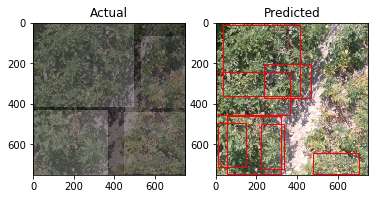

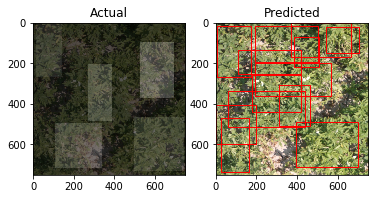

In [7]:
from numpy import expand_dims
from numpy import mean
from mrcnn import visualize
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from matplotlib.patches import Rectangle
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
class plantDataset(Dataset):
	# load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "healthy")
        self.add_class("dataset", 2, "unhealthy")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        for filename in listdir(images_dir):
        # extract image id
            image_id = filename[:-4]
            # skip all images after 225 if we are building the train set
            if is_train and int(image_id) >= 51:
                continue
            # skip all images before 225 if we are building the test/val set
            if not is_train and int(image_id) < 51:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
	          # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes_new(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box2 in root.findall('.//object'):
            xmin = int(box2.find('bndbox/xmin').text)
            ymin = int(box2.find('bndbox/ymin').text)
            xmax = int(box2.find('bndbox/xmax').text)
            ymax = int(box2.find('bndbox/ymax').text)
            class1 = str(box2.find('name').text)    
            coors = [xmin, ymin, xmax, ymax, class1]
            boxes.append(coors)   
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes_new(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(box[4]))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
       info = self.image_info[image_id]
       return info['path']

# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
  
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP


# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=1):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.2)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()
  

train_set = plantDataset()
train_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images', is_train=True)
train_set.prepare()


test_set = plantDataset()
test_set.load_dataset('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images', is_train=False)
test_set.prepare()

cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images/', config=cfg)
# load model weights
model.load_weights('drive/My Drive/Masters_Research_Project/Mask_RCNN/field_images/plant_cfg20191014T0025/mask_rcnn_plant_cfg_0050.h5', by_name=True)  
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)  